In [ ]:
# Read readme.md from github
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Challenge_1/"

Mounted at /gdrive
/gdrive/My Drive/Challenge_1


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["MPLCONFIGDIR"] = os.getcwd() + "/configs/"

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

import numpy as np

np.random.seed(seed)

import logging

import random

random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
import seaborn as sns

In [ ]:
from tensorflow.keras.optimizers import AdamW

In [ ]:
data = np.load('new_dataset.npz', allow_pickle=True) #If you are running it using Colab

In [ ]:
# Load labels
label_indexes = data["labels"]

In [ ]:
# Find unique labels and count them
unique, counts = np.unique(label_indexes, return_counts=True)
for i in range(len(unique)):
    print(unique[i], ":", counts[i])

healthy : 3199
unhealthy : 2001


In [ ]:
# Extract classes separately
healthy_labels = np.where(label_indexes == "healthy")[0]  # labels[labels == 'healthy']
unhealthy_labels = np.where(label_indexes == "unhealthy")[0]  # labels[labels == 'unhealthy']

In [ ]:
labels = np.unique(label_indexes)  # used in confusion matrix later

In [ ]:
# Extract images based on classes
healthy_images = data["data"][healthy_labels]
unhealthy_images = data["data"][unhealthy_labels]

## Normalize images

In [ ]:
def preprocess_input(image_input):
    images = []

    # Iterate through files in the specified folder
    for tmp in image_input:
        img = tmp.copy()

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[..., ::-1]

        # Make the image dataset squared
        dim = min(img.shape[:-1])
        img = img[
            (img.shape[0] - dim) // 2 : (img.shape[0] + dim) // 2,
            (img.shape[1] - dim) // 2 : (img.shape[1] + dim) // 2,
            :,
        ]

        # Resize the image to 96x96 pixels
        img = tfkl.Resizing(96, 96)(img)

        if img is not None:
            images.append(img)

    return np.array(images)

In [ ]:
# Test
healthy_images = preprocess_input(healthy_images)
unhealthy_images = preprocess_input(unhealthy_images)

## Show samples

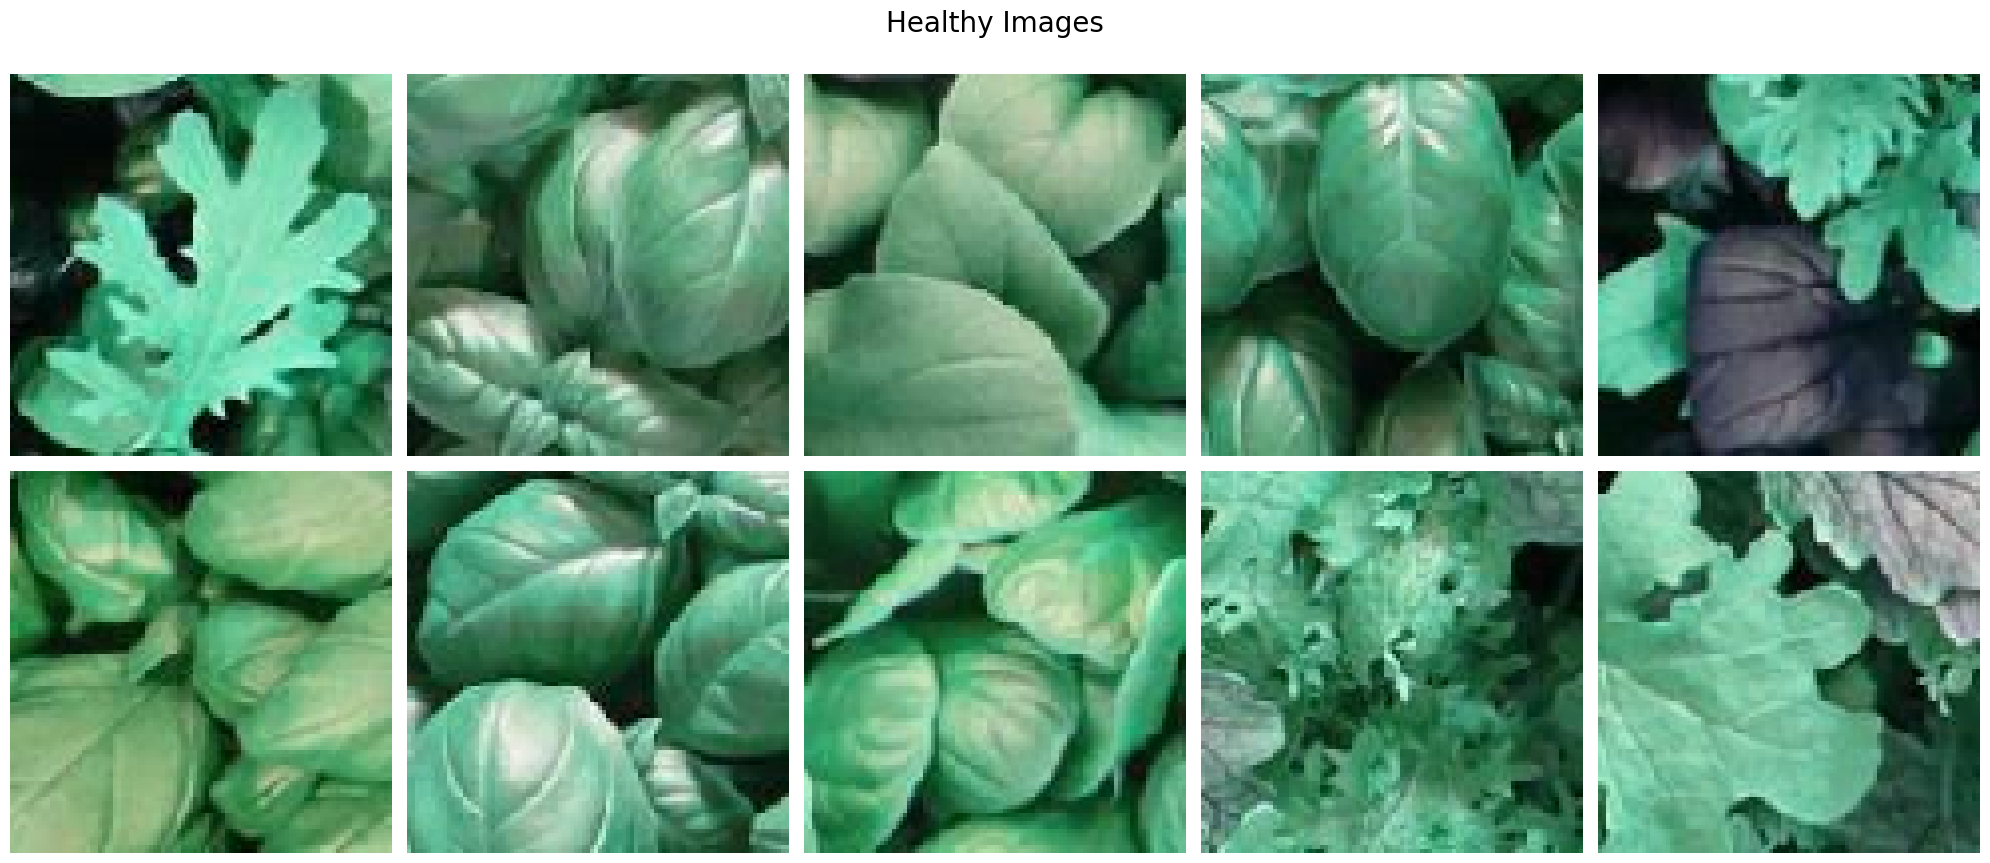

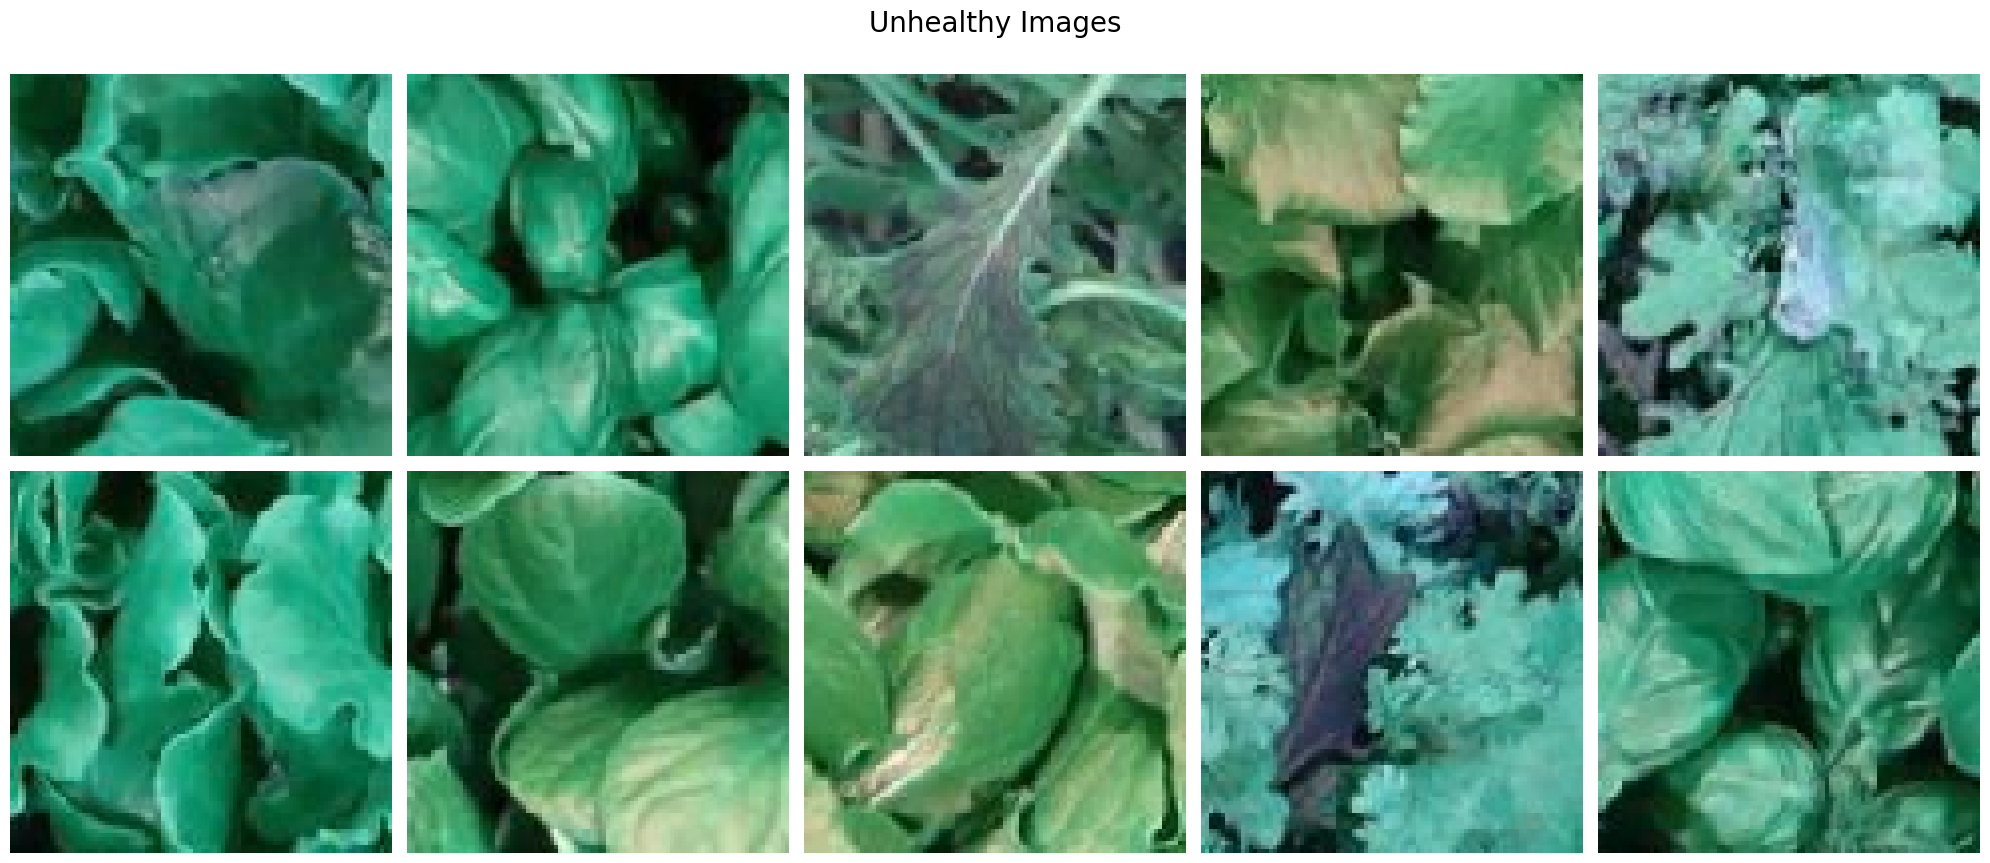

In [ ]:
# Number of images to display
num_img = 10

# Create subplots for displaying healthy images
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))
fig.suptitle("Healthy Images", fontsize=20)
for i in range(num_img):
    ax = axes[i % 2, i % num_img // 2]
    ax.imshow(np.clip(healthy_images[i], 0, 255))  # Display clipped healthy images
    ax.axis("off")
plt.tight_layout()
plt.show()

# Create subplots for displaying unhealthy images
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))
fig.suptitle("Unhealthy Images", fontsize=20)
for i in range(num_img):
    ax = axes[i % 2, i % num_img // 2]
    ax.imshow(np.clip(unhealthy_images[i], 0, 255))  # Display clipped unhealthy images
    ax.axis("off")
plt.tight_layout()
plt.show()

## Prepare data

In [ ]:
X = np.concatenate([healthy_images, unhealthy_images], axis=0)

# Create labels: 0 for 'healthy plants', 1 for 'unhealthy plants'
y = np.concatenate(
    [np.zeros(len(healthy_images)), np.onež(len(unhealthy_images))], axis=0
)

### Confirm specified output

In [ ]:
y[:5], y[-5:]

In [ ]:
# Convert labels to one-hot encoding
y = tfk.utils.to_categorical(y, len(np.unique(y)))

In [ ]:
y[:5], y[-5:]

In [ ]:
np.argmax(y, axis=1)[:5], np.argmax(y, axis=1)[-5:]

### Split data

In [ ]:
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, random_state=seed, test_size=0.25, stratify=np.argmax(y, axis=1)
)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    random_state=seed,
    test_size=len(X_test),
    stratify=np.argmax(y_train_val, axis=1),
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (2600, 96, 96, 3), y_train shape: (2600, 2)
X_val shape: (1300, 96, 96, 3), y_val shape: (1300, 2)
X_test shape: (1300, 96, 96, 3), y_test shape: (1300, 2)


### Neural network inputs

In [ ]:
# Define batch size, number of epochs, learning rate, input shape, and output shape
batch_size = 256
epochs = 1000
learning_rate = 1e-4
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]

# Print batch size, epochs, learning rate, input shape, and output shape
print(f"Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {learning_rate}")
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}")

Batch Size: 256, Epochs: 1000, Learning Rate: 0.0001
Input Shape: (96, 96, 3), Output Shape: 2


In [ ]:
# Define two callback functions for early stopping and learning rate reduction
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')
]

# Print the defined callbacks
print("Callbacks:")
for callback in callbacks:
    print(callback)

Callbacks:


## Architecture

### VGG-like architecture

In [ ]:
# Define a convolutional block function with multiple parameters
def conv_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    # Apply a stack of convolutional layers with specified filters, kernel size, and activation
    for s in range(stack):
        x = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x)
        x = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x)

    return x

In [ ]:
# Define a function to build a VGG18-like model
def build_model(input_shape=input_shape, output_shape=output_shape, learning_rate=learning_rate, seed=seed):

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input_Layer')

    # Define a preprocessing Sequential model with random flip, zero padding, and random crop
    preprocessing = tfk.Sequential([
        tfkl.RandomFlip('horizontal', name='RandomFlip_horizontal'),
        tfkl.ZeroPadding2D((2, 2), name='ZeroPadding_2x2'),
        tfkl.RandomCrop(input_shape[0], input_shape[1], name='RandomCrop')
    ], name='Preprocessing')

    # Apply preprocessing to input layer
    x0 = preprocessing(input_layer)

    # Initial convolution and activation
    x0 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create convolutional blocks
    x1 = conv_block(x=x0, filters=64, kernel_size=3, downsample=False, stack=2, name='1')
    x1 = conv_block(x=x1, filters=64, kernel_size=3, downsample=False, stack=2, name='2')

    x2 = conv_block(x=x1, filters=128, kernel_size=3, downsample=True, stack=2, name='3')
    x2 = conv_block(x=x2, filters=128, kernel_size=3, downsample=False, stack=2, name='4')

    x3 = conv_block(x=x2, filters=256, kernel_size=3, downsample=True, stack=2, name='5')
    x3 = conv_block(x=x3, filters=256, kernel_size=3, downsample=False, stack=2, name='6')

    x4 = conv_block(x=x3, filters=512, kernel_size=3, downsample=True, stack=2, name='7')
    x4 = conv_block(x=x4, filters=512, kernel_size=3, downsample=False, stack=2, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x4)
    x = tfkl.Dense(output_shape, name='Dense')(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='VGG18')

    # Define optimizer, loss, and metrics
    # AdamW is an Adam optimizer which applies weight_decay to network layers,
    # i.e it's another way to apply l2 regularization to the whole network
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    loss = tfk.losses.CategoricalCrossentropy()
    metrics = ['accuracy']

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

Model: "VGG18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 Preprocessing (Sequential)  (None, 96, 96, 3)         0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| RandomFlip_horizontal (Ra  (None, 96, 96, 3)         0        |
| ndomFlip)                                                     |
|                                                               |
| ZeroPadding_2x2 (ZeroPadd  (None, 100, 100, 3)       0        |
| ing2D)                                                        |
|                                                               |
| RandomCrop (RandomCrop)    (None, 96, 96, 3)         0        |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 Conv0 (Conv2D)              (None, 96, 96, 64)        1792  

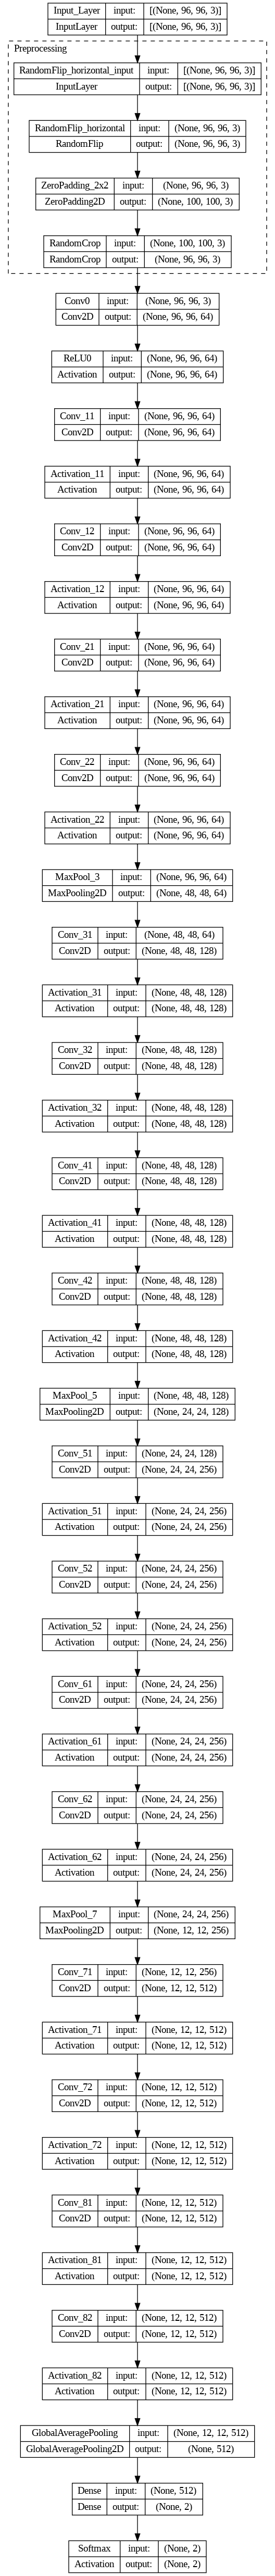

In [ ]:
baseline_model = build_model()
baseline_model.summary(expand_nested=True)
tfk.utils.plot_model(baseline_model, expand_nested=True, show_shapes=True)

In [ ]:
baseline_history = baseline_model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/1000
11/11 [==============================] - 49s 2s/step - loss: 0.6823 - accuracy: 0.5927 - val_loss: 0.6650 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 2/1000
11/11 [==============================] - 14s 1s/step - loss: 0.6642 - accuracy: 0.6150 - val_loss: 0.6605 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 3/1000
11/11 [==============================] - 15s 1s/step - loss: 0.6641 - accuracy: 0.6150 - val_loss: 0.6560 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 4/1000
11/11 [==============================] - 15s 1s/step - loss: 0.6578 - accuracy: 0.6150 - val_loss: 0.6573 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 5/1000
11/11 [==============================] - 14s 1s/step - loss: 0.6596 - accuracy: 0.6150 - val_loss: 0.6535 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 6/1000
11/11 [==============================] - 14s 1s/step - loss: 0.6527 - accuracy: 0.6150 - val_loss: 0.6627 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 7/1000
11/11 [==========================

### VGG-like architecture with Batch Normalization

In [ ]:
# Define a convolutional block with batch normalization option
def conv_bn_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=True, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    # Apply a stack of convolutional layers with optional batch normalization and specified activation
    for s in range(stack):
        x = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x)
        if batch_norm:
            x = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x)
        x = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x)

    return x

In [ ]:
# Define a function to build a VGG18-like model with batch normalization
def build_bn_model(input_shape=input_shape, output_shape=output_shape, learning_rate=1e-4, seed=seed):

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input_Layer')

    # Define a preprocessing Sequential model with random flip, zero padding, and random crop
    preprocessing = tfk.Sequential([
        tfkl.RandomFlip('horizontal', name='RandomFlip_horizontal'),
        tfkl.ZeroPadding2D((2, 2), name='ZeroPadding_2x2'),
        tfkl.RandomCrop(input_shape[0], input_shape[1], name='RandomCrop')
    ], name='Preprocessing')

    # Apply preprocessing to the input layer
    x0 = preprocessing(input_layer)

    # Initial convolution with batch normalization and activation
    x0 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv0')(x0)
    x0 = tfkl.BatchNormalization(name='BatchNorm0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create convolutional blocks with batch normalization
    x1 = conv_bn_block(x=x0, filters=64, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='1')
    x1 = conv_bn_block(x=x1, filters=64, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='2')

    x2 = conv_bn_block(x=x1, filters=128, kernel_size=3, downsample=True, stack=2, batch_norm=True, name='3')
    x2 = conv_bn_block(x=x2, filters=128, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='4')

    x3 = conv_bn_block(x=x2, filters=256, kernel_size=3, downsample=True, stack=2, batch_norm=True, name='5')
    x3 = conv_bn_block(x=x3, filters=256, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='6')

    x4 = conv_bn_block(x=x3, filters=512, kernel_size=3, downsample=True, stack=2, batch_norm=True, name='7')
    x4 = conv_bn_block(x=x4, filters=512, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x4)
    x = tfkl.Dense(output_shape, name='Dense')(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='VGG18_BN')

    # Define optimizer, loss, and metrics
    # AdamW is an Adam optimizer which applies weight_decay to network layers,
    # i.e it's another way to apply l2 regularization to the whole network
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    loss = tfk.losses.CategoricalCrossentropy()
    metrics = ['accuracy']

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

Model: "VGG18_BN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 Preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 Conv0 (Conv2D)              (None, 96, 96, 64)        1792      
                                                                 
 BatchNorm0 (BatchNormaliza  (None, 96, 96, 64)        256       
 tion)                                                           
                                                                 
 ReLU0 (Activation)          (None, 96, 96, 64)        0         
                                                                 
 Conv_11 (Conv2D)            (None, 96, 96, 64)        36928     
                                                          

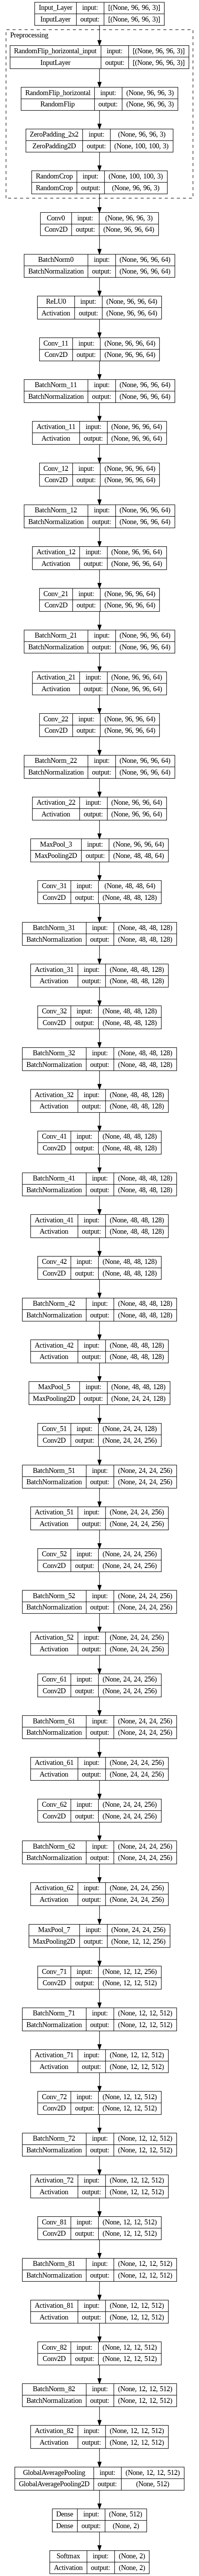

In [ ]:
bn_model = build_bn_model()
bn_model.summary()
tfk.utils.plot_model(bn_model, expand_nested=True, show_shapes=True)

In [ ]:
bn_history = bn_model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/1000
11/11 [==============================] - 41s 2s/step - loss: 0.6479 - accuracy: 0.6381 - val_loss: 0.6828 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 2/1000
11/11 [==============================] - 18s 2s/step - loss: 0.5110 - accuracy: 0.7508 - val_loss: 0.6695 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 3/1000
11/11 [==============================] - 18s 2s/step - loss: 0.4608 - accuracy: 0.7800 - val_loss: 0.6680 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 4/1000
11/11 [==============================] - 17s 2s/step - loss: 0.4372 - accuracy: 0.8015 - val_loss: 0.6863 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 5/1000
11/11 [==============================] - 17s 2s/step - loss: 0.4335 - accuracy: 0.8027 - val_loss: 0.7753 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 6/1000
11/11 [==============================] - 17s 2s/step - loss: 0.4136 - accuracy: 0.8108 - val_loss: 0.8069 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 7/1000
11/11 [==========================

### VGG-like architecture with Batch Normalization and Skip Connections (Residual VGG)

In [ ]:
# Define a residual convolutional block with optional batch normalization
def conv_residual_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=True, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    # Create a copy of the input for the residual connection
    x_ = x

    # Apply a stack of convolutional layers to the copy
    for s in range(stack):
        x_ = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x_)
        if batch_norm:
            x_ = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x_)
        x_ = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x_)

    # If downsample is True, apply a 1x1 convolution to match the number of filters
    if downsample:
        x = tfkl.Conv2D(filters=filters, kernel_size=1, padding=padding, name='Conv_' + name + 'skip')(x)

    # Add the original and the processed copy to create the residual connection
    x = tfkl.Add(name='Add_' + name)([x_, x])

    return x

In [ ]:
# Define a function to build a VGG18-like model with residual blocks
def build_model_residual(input_shape=input_shape, output_shape=output_shape, learning_rate=1e-4, seed=seed):

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input_Layer')

    # Define a preprocessing Sequential model with random flip, zero padding, and random crop
    preprocessing = tfk.Sequential([
        tfkl.RandomFlip('horizontal', name='RandomFlip_horizontal'),
        tfkl.ZeroPadding2D((2, 2), name='ZeroPadding_2x2'),
        tfkl.RandomCrop(input_shape[0], input_shape[1], name='RandomCrop')
    ], name='Preprocessing')

    # Apply preprocessing to the input layer
    x0 = preprocessing(input_layer)

    # Initial convolution with batch normalization and activation
    x0 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv0')(x0)
    x0 = tfkl.BatchNormalization(name='BatchNorm0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create residual blocks
    x1 = conv_residual_block(x=x0, filters=64, kernel_size=3, downsample=False, stack=2, name='1')
    x1 = conv_residual_block(x=x1, filters=64, kernel_size=3, downsample=False, stack=2, name='2')

    x2 = conv_residual_block(x=x1, filters=128, kernel_size=3, downsample=True, stack=2, name='3')
    x2 = conv_residual_block(x=x2, filters=128, kernel_size=3, downsample=False, stack=2, name='4')

    x3 = conv_residual_block(x=x2, filters=256, kernel_size=3, downsample=True, stack=2, name='5')
    x3 = conv_residual_block(x=x3, filters=256, kernel_size=3, downsample=False, stack=2, name='6')

    x4 = conv_residual_block(x=x3, filters=512, kernel_size=3, downsample=True, stack=2, name='7')
    x4 = conv_residual_block(x=x4, filters=512, kernel_size=3, downsample=False, stack=2, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x4)
    x = tfkl.Dense(output_shape, name='Dense')(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='VGG18_Residual')

    # Define optimizer, loss, and metrics
    # AdamW is an Adam optimizer which applies weight_decay to network layers,
    # i.e it's another way to apply l2 regularization to the whole network
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    loss = tfk.losses.CategoricalCrossentropy()
    metrics = ['accuracy']

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

Model: "VGG18_Residual"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Preprocessing (Sequential)  (None, 96, 96, 3)            0         ['Input_Layer[0][0]']         
                                                                                                  
 Conv0 (Conv2D)              (None, 96, 96, 64)           1792      ['Preprocessing[0][0]']       
                                                                                                  
 BatchNorm0 (BatchNormaliza  (None, 96, 96, 64)           256       ['Conv0[0][0]']               
 tion)                                                                               

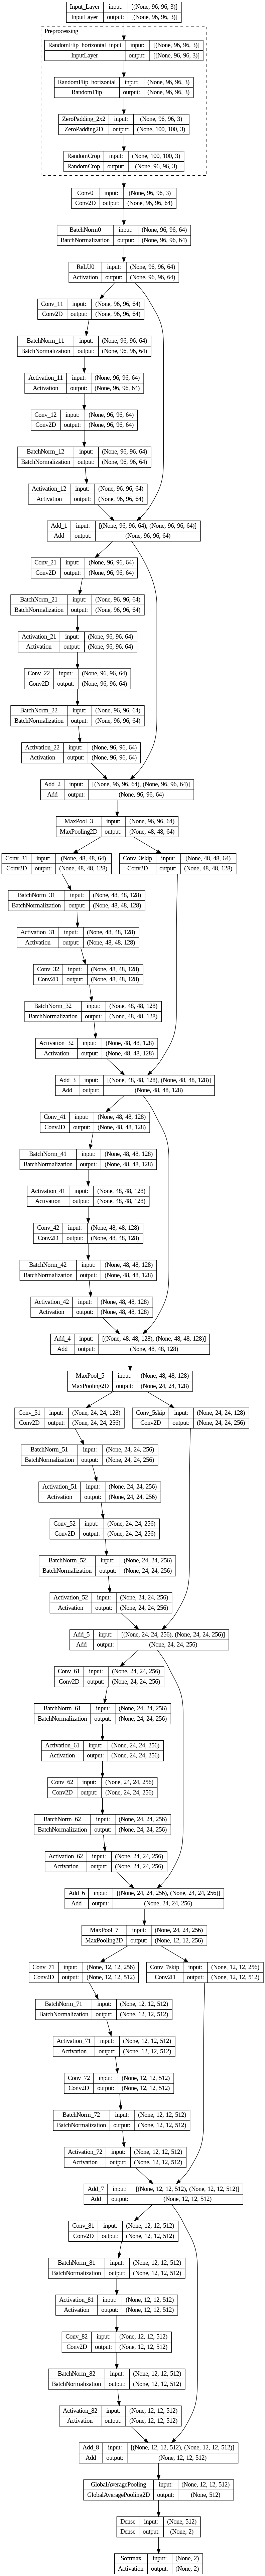

In [ ]:
residual_model = build_model_residual()
residual_model.summary()
tfk.utils.plot_model(residual_model, expand_nested=True, show_shapes=True)

In [ ]:
residual_history = residual_model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=epochs,
    batch_size=160,
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/1000
17/17 [==============================] - 35s 1s/step - loss: 0.5797 - accuracy: 0.7142 - val_loss: 0.9190 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 2/1000
17/17 [==============================] - 21s 1s/step - loss: 0.4821 - accuracy: 0.7788 - val_loss: 1.3347 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 3/1000
17/17 [==============================] - 21s 1s/step - loss: 0.4344 - accuracy: 0.8012 - val_loss: 2.1061 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 4/1000
17/17 [==============================] - 19s 1s/step - loss: 0.4191 - accuracy: 0.8038 - val_loss: 1.7527 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 5/1000
17/17 [==============================] - 21s 1s/step - loss: 0.4208 - accuracy: 0.8081 - val_loss: 3.2066 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 6/1000
17/17 [==============================] - 21s 1s/step - loss: 0.3732 - accuracy: 0.8304 - val_loss: 3.2271 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 7/1000
17/17 [==========================

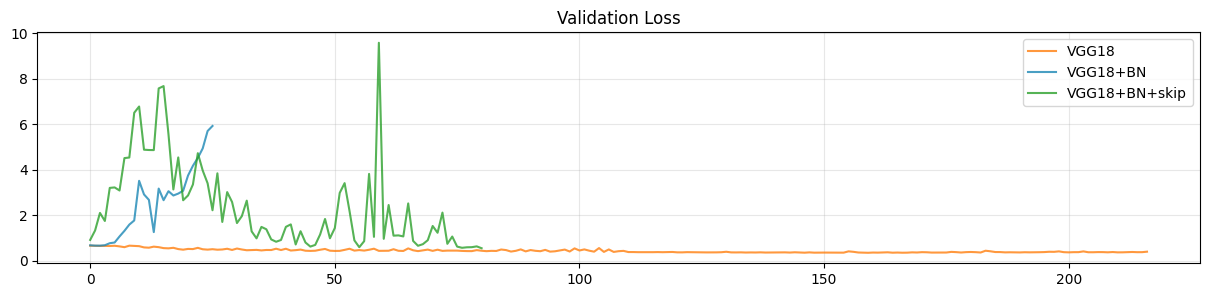

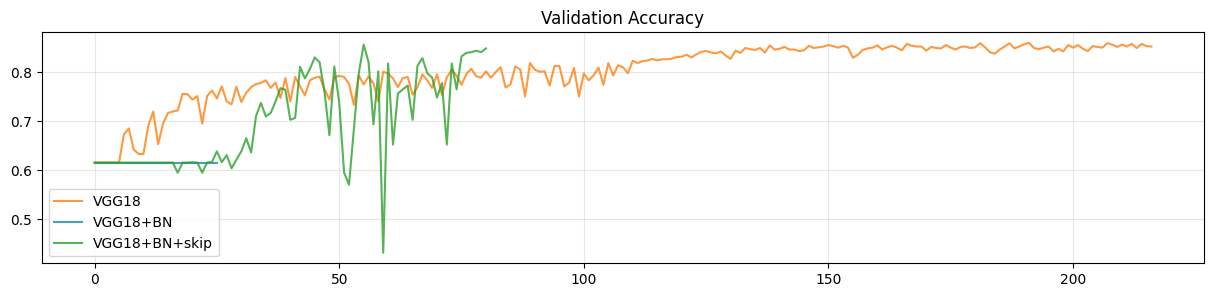

In [ ]:
# Plot validation loss for different models
plt.figure(figsize=(15, 3))
plt.plot(baseline_history['val_loss'], label='VGG18', alpha=0.8, color='#ff7f0e')
plt.plot(bn_history['val_loss'], label='VGG18+BN', alpha=0.8, color='#1B87B5')
plt.plot(residual_history['val_loss'], label='VGG18+BN+skip', alpha=0.8, color='#2ca02c')
plt.title('Validation Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot validation accuracy for different models
plt.figure(figsize=(15, 3))
plt.plot(baseline_history['val_accuracy'], label='VGG18', alpha=0.8, color='#ff7f0e')
plt.plot(bn_history['val_accuracy'], label='VGG18+BN', alpha=0.8, color='#1B87B5')
plt.plot(residual_history['val_accuracy'], label='VGG18+BN+skip', alpha=0.8, color='#2ca02c')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)

# Show the plots
plt.show()

## Residual model

In [ ]:
residual_model.save('residual_model')
del residual_model

In [ ]:
# Load the saved residual model
residual_model = tfk.models.load_model('residual_model')

In [ ]:
# Predict labels for the entire test set
predictions = residual_model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (1300, 2)


Accuracy: 0.8615
Precision: 0.8539
Recall: 0.8534
F1: 0.8536


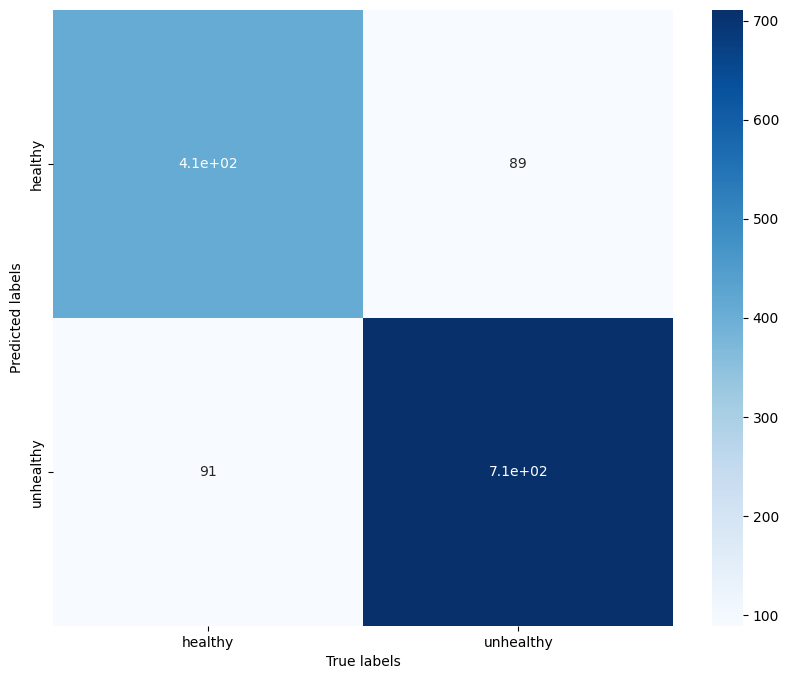

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list((labels)), yticklabels=list((labels)), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Batch model

In [ ]:
bn_model.save('batch-model')
del bn_model

In [ ]:
# Load the saved residual model
bn_model = tfk.models.load_model('batch-model')

In [ ]:
# Predict labels for the entire test set
predictions = bn_model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (1300, 2)


Accuracy: 0.6154
Precision: 0.3077
Recall: 0.5
F1: 0.381


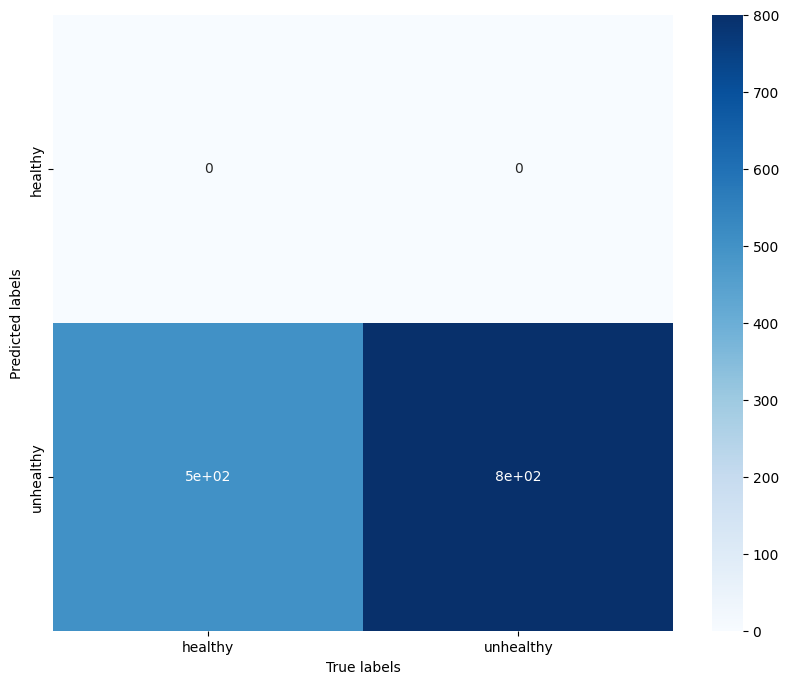

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list((labels)), yticklabels=list((labels)), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## BaseLine model

In [ ]:
baseline_model.save('baseline_model')
del baseline_model

In [ ]:
# Load the saved residual model
baseline_model = tfk.models.load_model('baseline_model')

In [ ]:
# Predict labels for the entire test set
predictions = baseline_model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (1300, 2)


Accuracy: 0.8485
Precision: 0.8434
Recall: 0.8334
F1: 0.8377


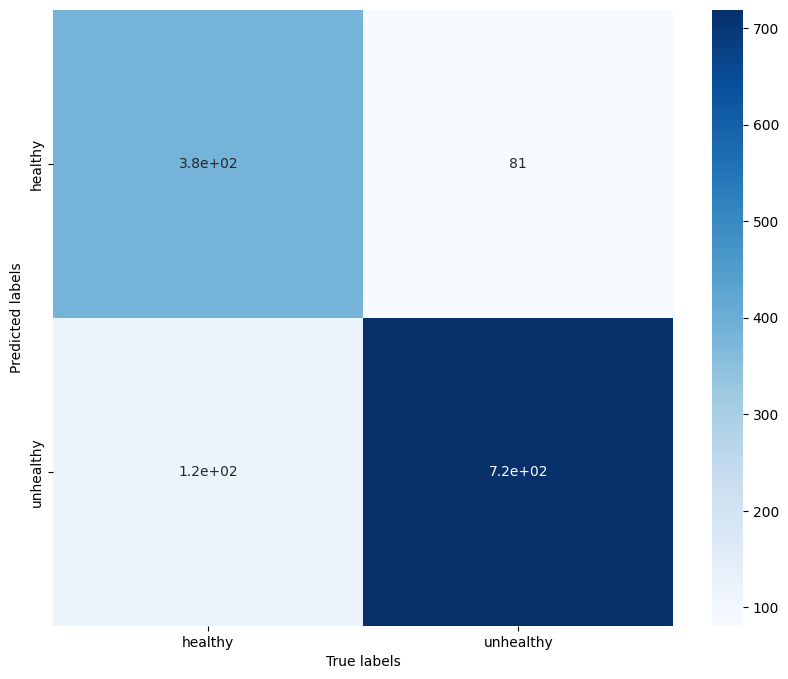

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list((labels)), yticklabels=list((labels)), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()